## La Loma, Cesar

In [111]:
from seismoly import window,descrp
from numpy import dot
from numpy.linalg import norm
from obspy import read,read_inventory
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score

**Antecedentes**<br>
-   https://www.elheraldo.co/economia/consejo-de-estado-ordena-suspender-produccion-de-gas-de-drummond-en-campo-la-loma-687184
-   https://co.boell.org/es/2022/09/12/pierden-con-el-carbon-y-sin-el-los-dilemas-de-la-transicion-energetica-en-cesar
-   https://elpilon.com.co/consejo-de-estado-revoco-medida-que-suspendia-trabajo-de-drummond-en-15-pozos-del-cesar/
-   https://guiadelgas.com/industria/consejo-de-estado-suspende-15-pozos-de-drummond-en-el-campo-la-loma/
-   https://www.semana.com/impacto/articulo/drummond-tendra-que-suspender-operaciones-en-15-pozos-de-gas-en-el-cesar/48075/
-   https://www.elheraldo.co/economia/consejo-de-estado-ordena-suspender-produccion-de-gas-de-drummond-en-campo-la-loma-687184 <br>
"Las actividades de estimulación hidráulica se adelantaron entre el 14 de marzo de 2018 y el tercer trimestre del mismo año, por medio de la perforación de 15 pozos. Esos pozos actualmente se encuentran en fase de producción."

In [132]:
st = read("data\LL8C_13_18_MAR.mseed")
# inv = read_inventory('data\CM.GUY2C.dataless')
st1 = st.select(channel='HHZ')
tr=st1[0]
for i in st1[1::]:
    tr=tr+i
tr=tr.filter('highpass', freq=0.1, corners=2, zerophase=True)

In [133]:
all,ovlp=window(tr.data,tr.stats.delta,60,80)
f=tr.stats.sampling_rate
dt=tr.stats.delta
val_descr=[]
for i in all:
    val_descr.append(descrp(i,dt))
descr=np.array(val_descr)

C:\Users\jujim\AppData\Local\Temp\ipykernel_18768\3935002079.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  descr=np.array(val_descr)
C:\Users\jujim\AppData\Local\Temp\ipykernel_18768\3935002079.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  descr=np.array(val_descr)


In [134]:
df=pd.DataFrame()
for val,col in zip([descr[:,0],descr[:,1],descr[:,2],descr[:,3],descr[:,4],descr[:,5],descr[:,6]],['raw','std','kur','skewt','skewf','pkfreq','prfreq']):
    df[col]=val

In [116]:
##SE DEMORA UN TIEMPO CONSIDERABLE
# wcss = []
# silh = []
# dbs  = []
# ran1=2
# ran2=20
# for i in range(ran1,ran2):
#     kmeans = KMeans( i, init = 'k-means++', random_state = 42)
#     kmeans.fit(df[['std','kur','skewt','skewf','pkfreq','prfreq']].values)
#     labels = kmeans.labels_
#     wcss.append(kmeans.inertia_)
#     dbs.append(davies_bouldin_score(df[['std','kur','skewt','skewf','pkfreq','prfreq']].values, labels))
#     silh.append(silhouette_score(df[['std','kur','skewt','skewf','pkfreq','prfreq']].values, labels))

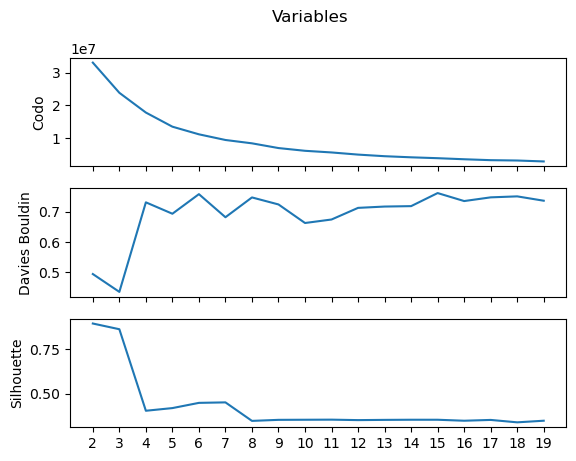

In [117]:
# fig, axs = plt.subplots(3,sharex=True)
# fig.suptitle('Variables')
# axs[0].plot(range(ran1,ran2), wcss)
# axs[0].set_ylabel('Codo')
# axs[1].plot(range(ran1,ran2), dbs)
# axs[1].set_ylabel('Davies Bouldin')
# axs[2].plot(range(ran1,ran2), silh)
# axs[2].set_ylabel('Silhouette')
# plt.xticks(range(ran1,ran2))
# plt.show()

In [148]:
kmeans = KMeans(3, init = 'k-means++', random_state = 42)
kmeans.fit(df[['std','kur','skewt','skewf','pkfreq','prfreq']].values)
labels = kmeans.labels_
df['cluster']=labels

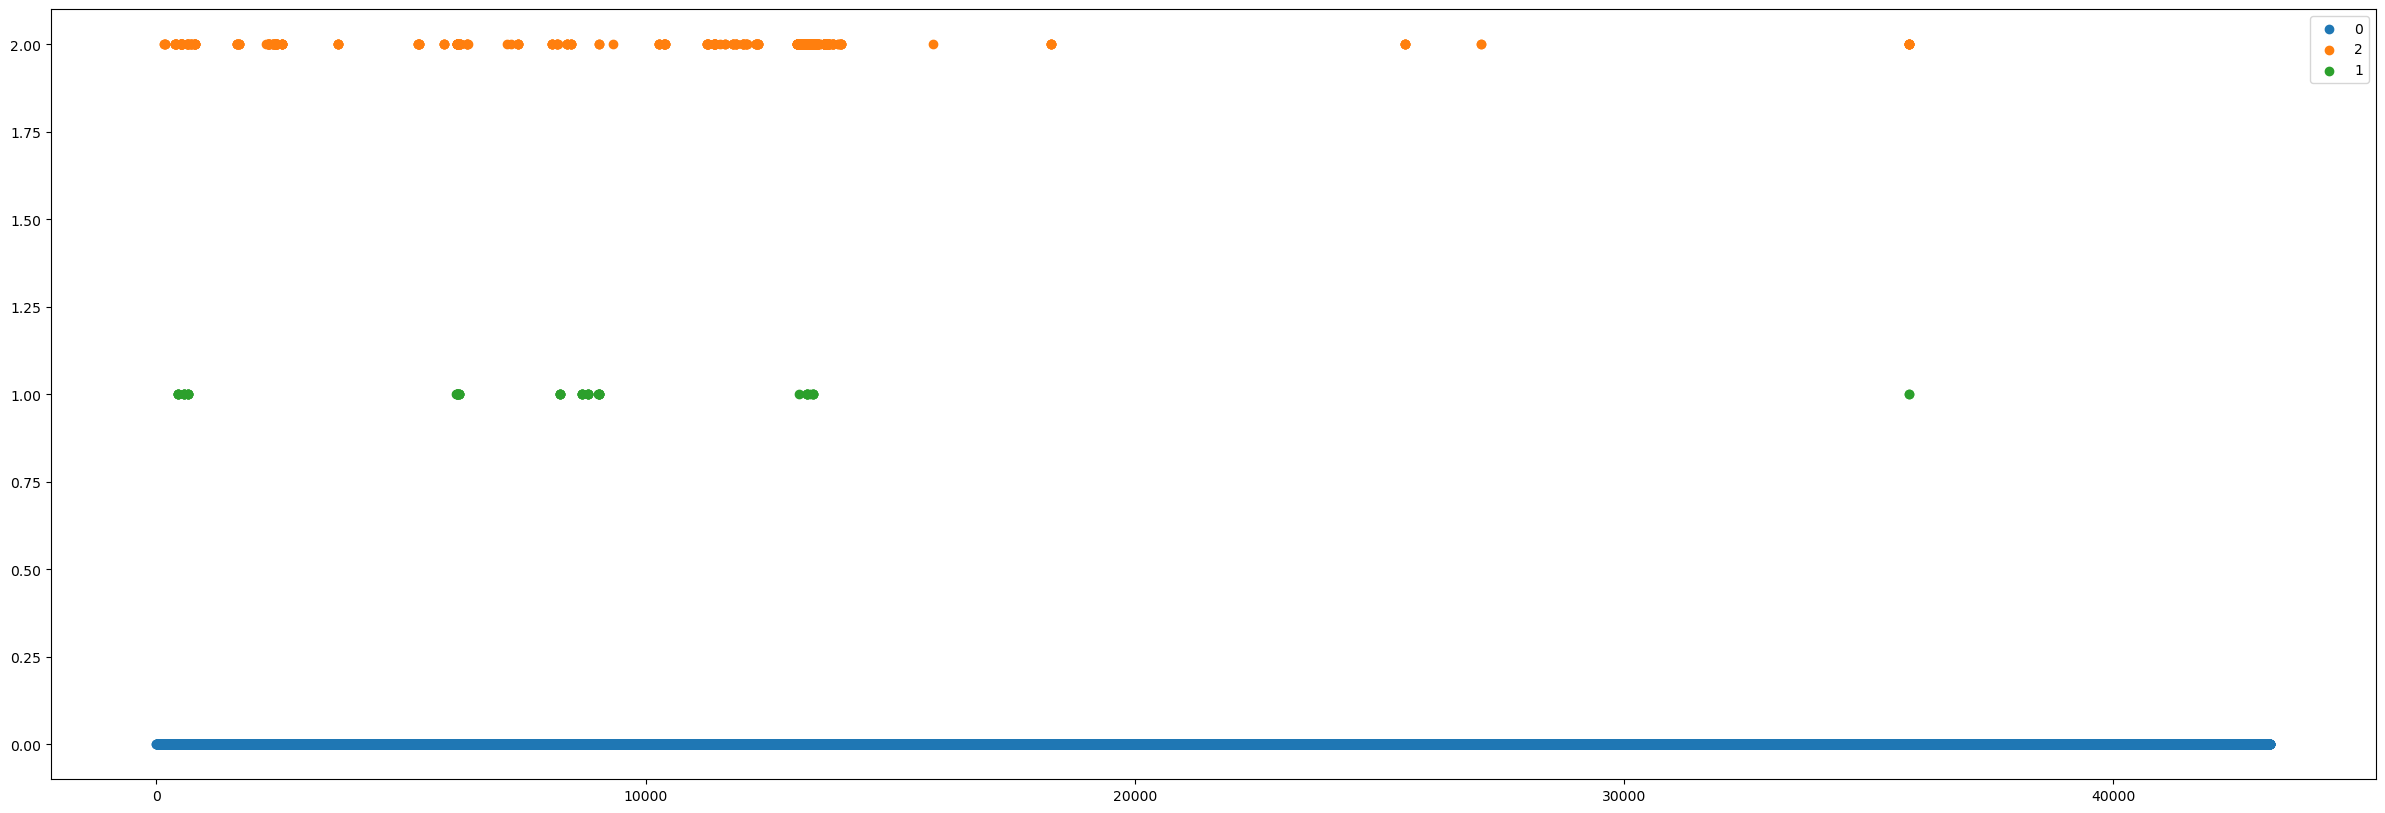

In [149]:
plt.figure(figsize=(30,10))
for i in df['cluster'].unique():
    df1=df[df['cluster']==i]
    plt.scatter(df1.index,df1['cluster'],label=str(i))
plt.legend()

In [150]:
hour=((3600/tr.stats.delta)/ovlp)-1
ran1=0
ran2=hour
ls_stats_hour=[]
for i in range(int((len(all))/((3600/tr.stats.delta)/ovlp))):
    df1=df.iloc[int(ran1):int(ran2+1),-1]
    ls_stats_hour.append(df1.value_counts().rename(i))
    ran1+=hour
    ran2+=hour
stats=pd.concat(ls_stats_hour,axis=1)
stats=stats.replace(np.nan,0)

In [151]:
init=11
ls=[0]
for i in range(12):
    ls.append(init)
    init=init+12

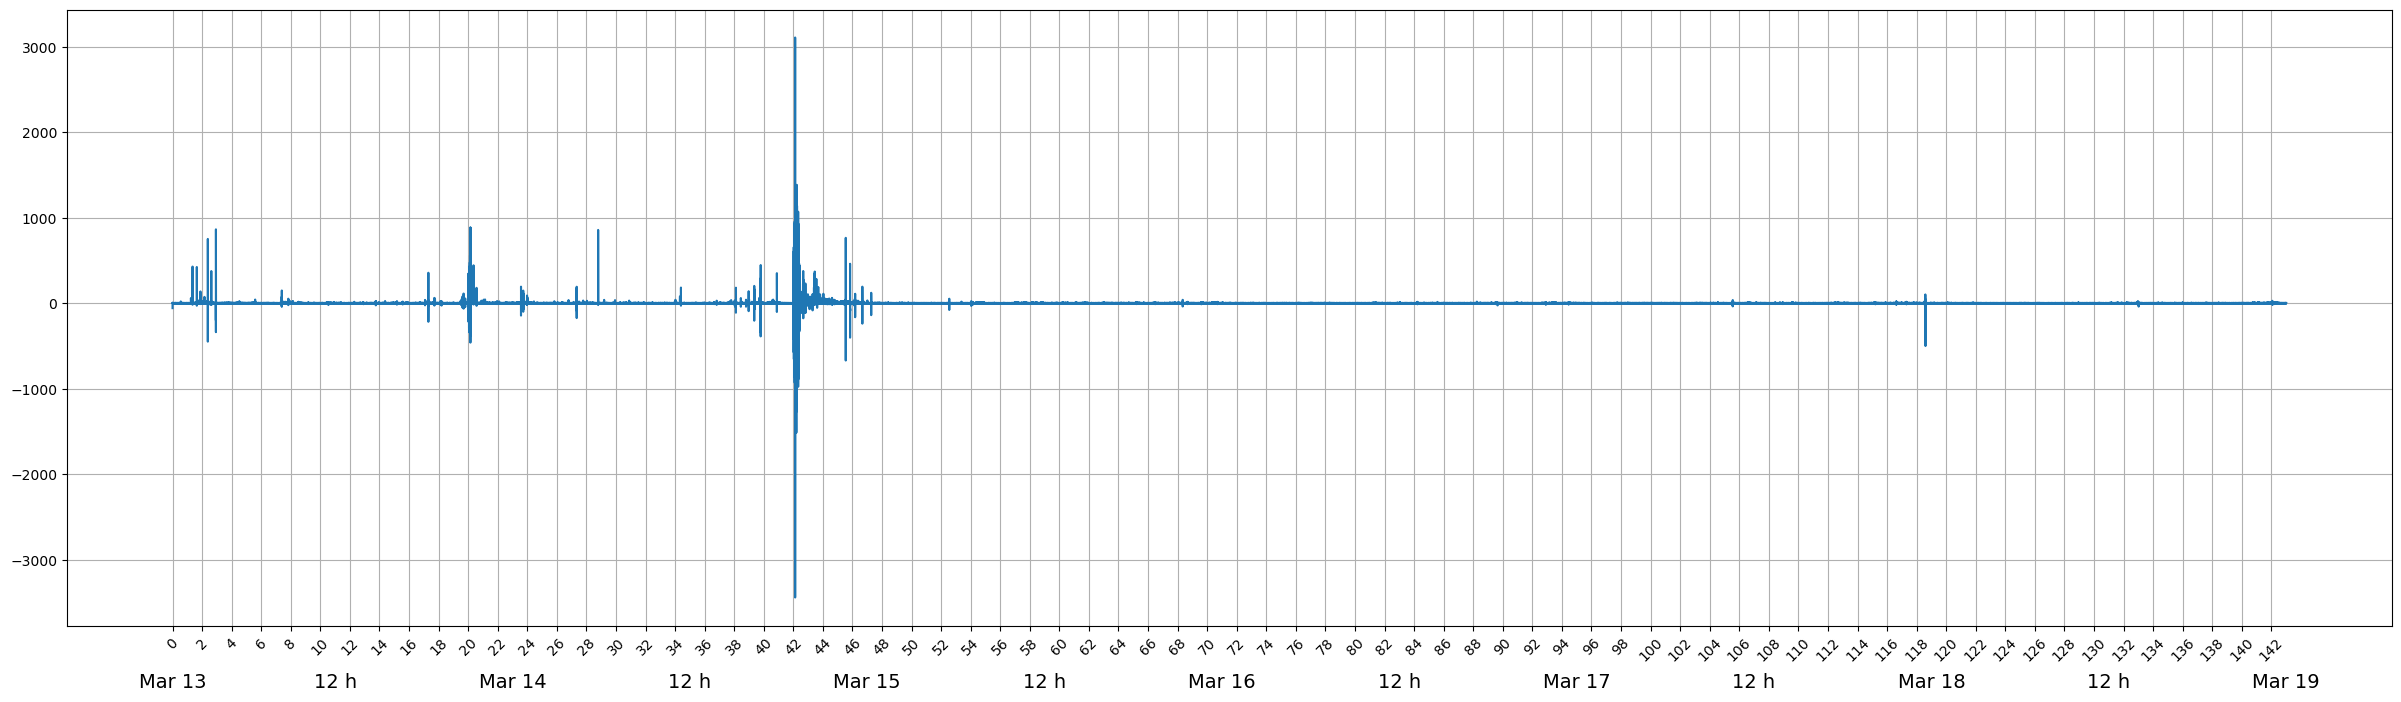

In [152]:
plt.figure(figsize=(30,8))
plt.plot(np.linspace(0,stats.columns[-1],len(tr.data))[0:-1:12],tr.data[0:-1:12])
plt.xticks(stats.columns[0:-1:2],rotation=45)
for i, x in zip(['Mar 13','12 h','Mar 14','12 h','Mar 15','12 h','Mar 16','12 h','Mar 17','12 h','Mar 18','12 h','Mar 19'],ls):
    plt.text(x, -4500, str(i), size=14, ha='center')
plt.grid()
plt.show()

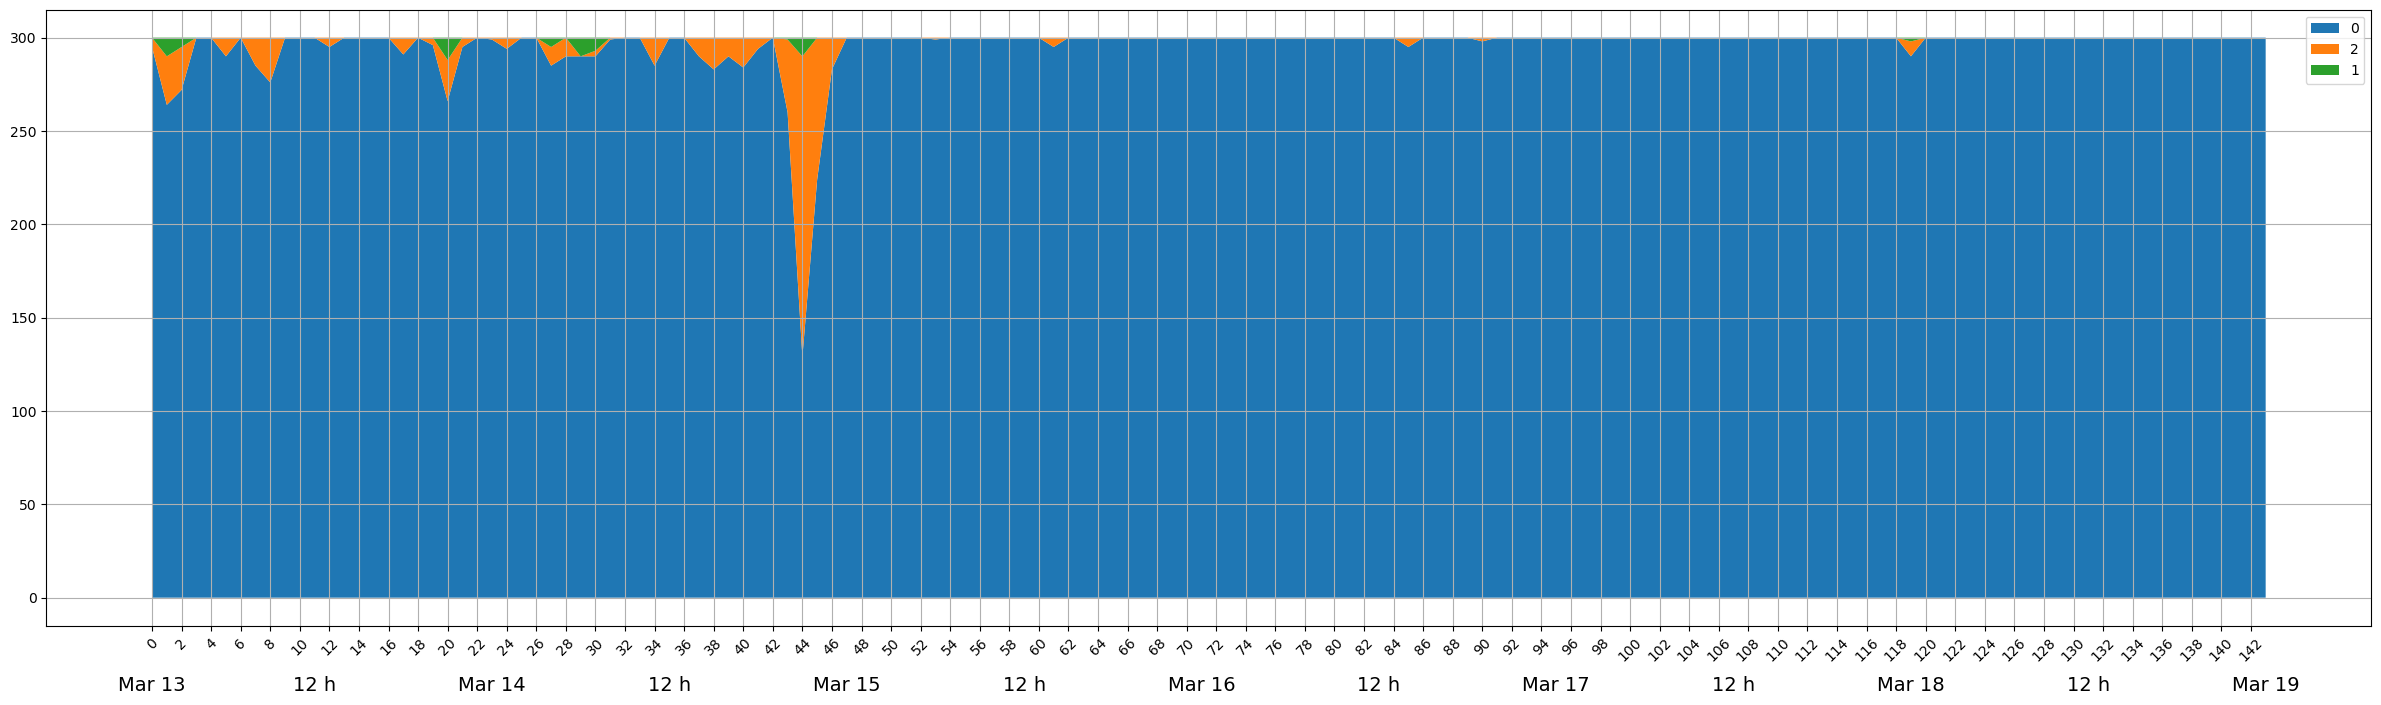

In [160]:
plt.figure(figsize=(30,8))
plt.fill_between(stats.columns,stats.values[0],0,label='0')
for i,idx in zip(range(1,len(stats.values)),stats.index[1::]):
    plt.fill_between(stats.columns,np.sum(stats.values[0:i+1],axis=0),np.sum(stats.values[0:i],axis=0),label=str(idx))
    # plt.fill_between(stats.columns,np.sum(stats.values[0:3],axis=0),np.sum(stats.values[0:2],axis=0),label='1')
    # plt.fill_between(stats.columns,np.sum(stats.values[0:4],axis=0),np.sum(stats.values[0:3],axis=0),label='2')
plt.xticks(stats.columns[0:-1:2],rotation=45)
for i, x in zip(['Mar 13','12 h','Mar 14','12 h','Mar 15','12 h','Mar 16','12 h','Mar 17','12 h','Mar 18','12 h','Mar 19'],ls):
    plt.text(x, -50, str(i), size=14, ha='center')
plt.grid()
plt.legend()
plt.show()

Text(0, 0.5, 'prfreq')

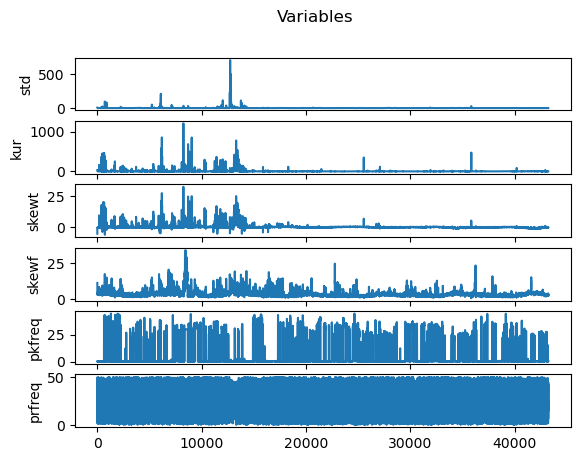

In [154]:
# plt.figure(figsize=(50,10))
fig, axs = plt.subplots(6,sharex=True)
fig.suptitle('Variables')
axs[0].plot(descr[:,1])
axs[0].set_ylabel('std')
axs[1].plot(descr[:,2])
axs[1].set_ylabel('kur')
axs[2].plot(descr[:,3])
axs[2].set_ylabel('skewt')
axs[3].plot(descr[:,4])
axs[3].set_ylabel('skewf')
axs[4].plot(descr[:,5])
axs[4].set_ylabel('pkfreq')
axs[5].plot(descr[:,6])
axs[5].set_ylabel('prfreq')

In [155]:
for i in [ 'std', 'kur', 'skewt', 'skewf', 'pkfreq', 'prfreq']:
    df[i]=df[i].astype(float)
ls_sim=[]
for i in df['cluster'].unique():
    df1=df[df['cluster']==i]
    sim=[]
    patron=df1.describe().iloc[1,:-1].values
    for i in df1[[ 'std', 'kur', 'skewt', 'skewf', 'pkfreq', 'prfreq']].values:
        sim.append(dot(patron, i)/(norm(patron)*norm(i)))
    df1['similarity']=sim
    ls_sim.append(df1)

C:\Users\jujim\AppData\Local\Temp\ipykernel_18768\3663590319.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['similarity']=sim
C:\Users\jujim\AppData\Local\Temp\ipykernel_18768\3663590319.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['similarity']=sim
C:\Users\jujim\AppData\Local\Temp\ipykernel_18768\3663590319.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

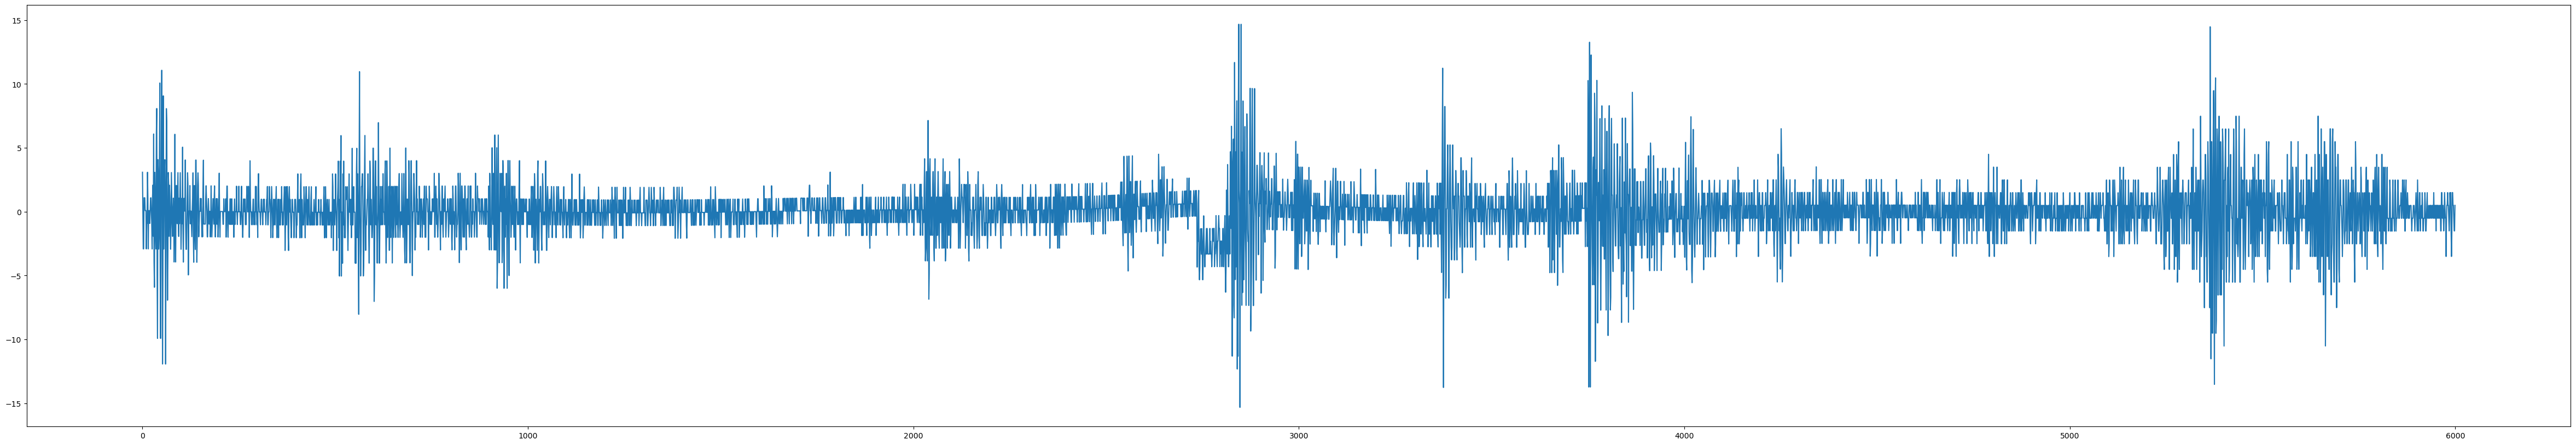

In [156]:
plt.figure(figsize=(60,10))
plt.plot(ls_sim[0].sort_values(by='similarity',ascending=False).iloc[30,0])

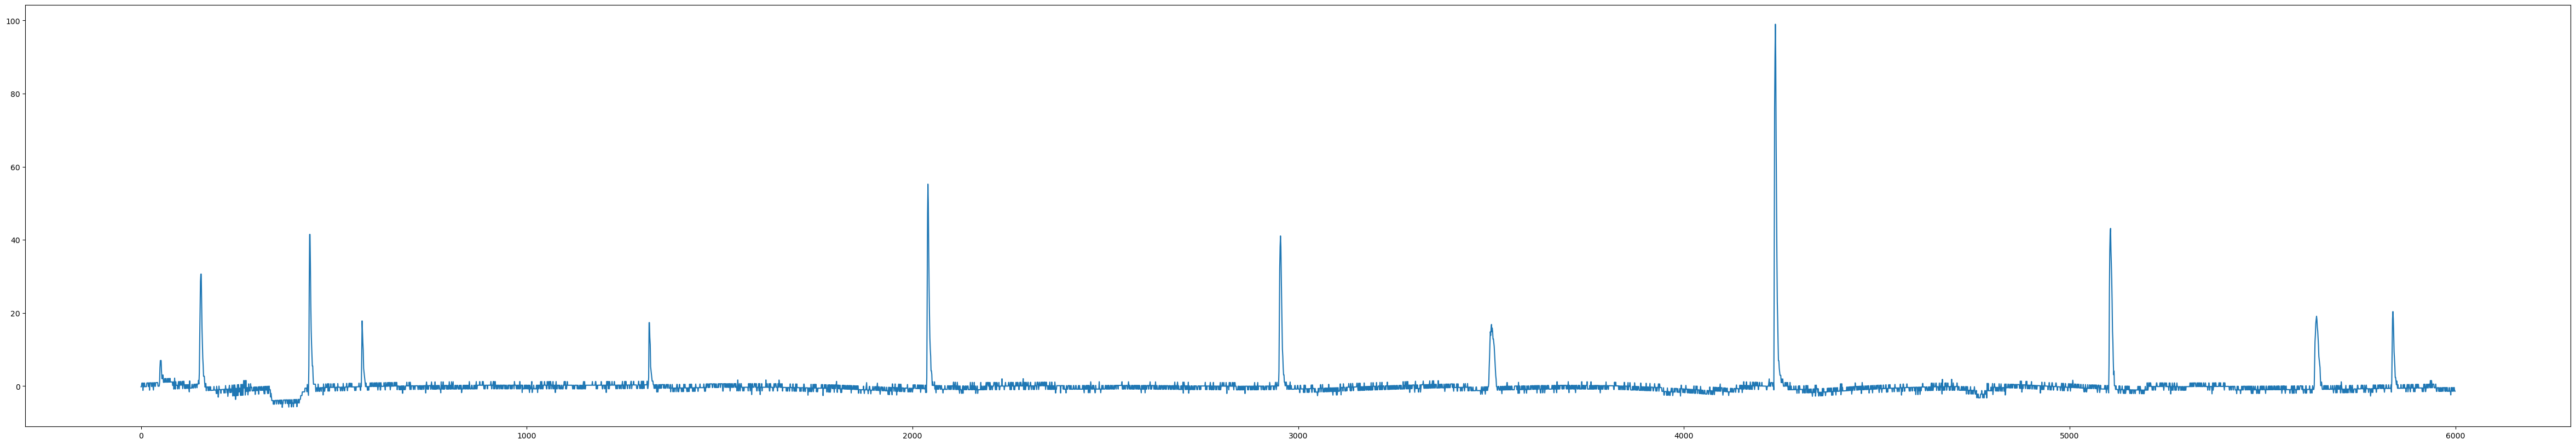

In [157]:
plt.figure(figsize=(60,10))
plt.plot(ls_sim[1].sort_values(by='similarity',ascending=False).iloc[0,0])

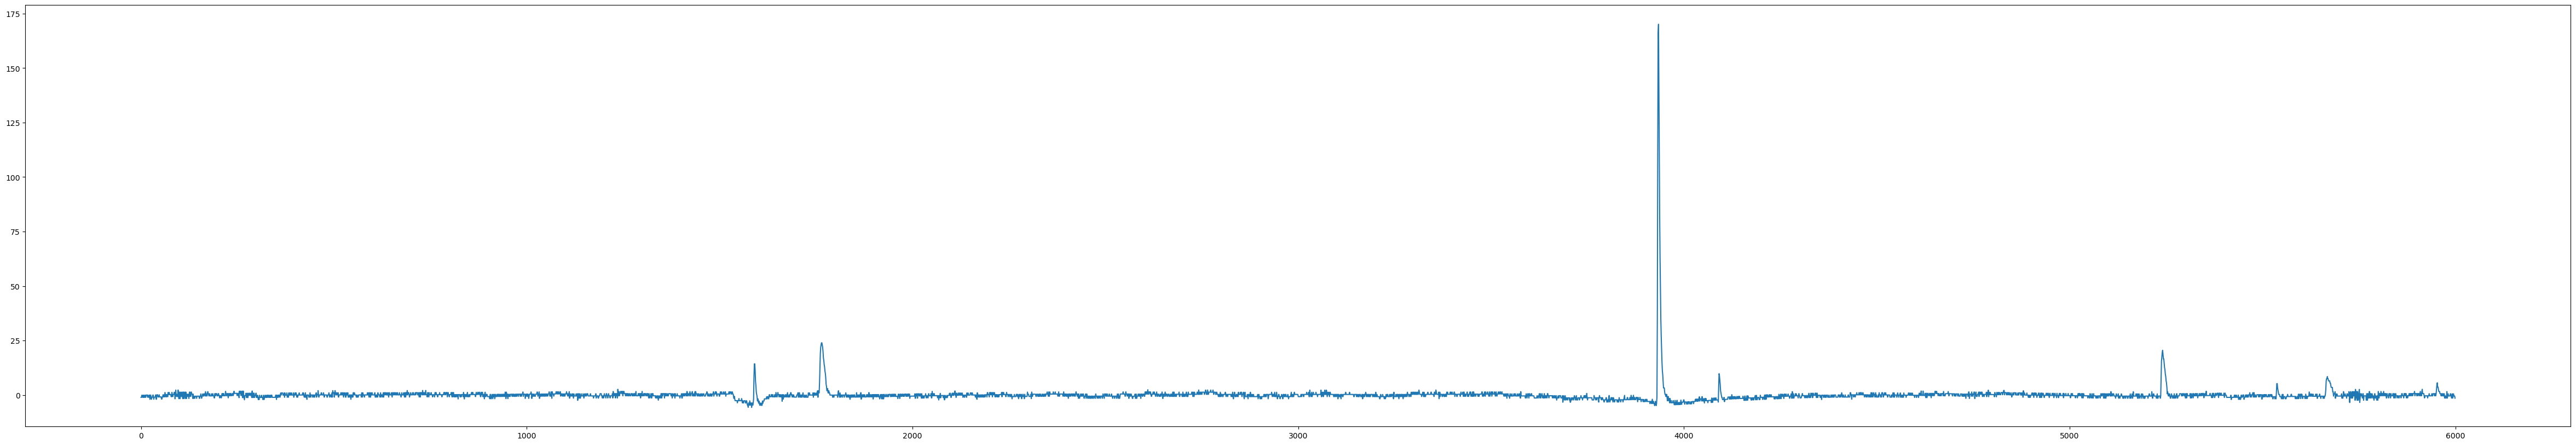

In [158]:
plt.figure(figsize=(60,10))
plt.plot(ls_sim[2].sort_values(by='similarity',ascending=False).iloc[1,0])

In [159]:
plt.figure(figsize=(60,10))
plt.plot(ls_sim[3].sort_values(by='similarity',ascending=False).iloc[0,0])

IndexError: list index out of range

<Figure size 6000x1000 with 0 Axes>

## Referencias

-   Watson, L. M. (2020). Using unsupervised machine learning  to identify changes in eruptive behavior at Mount Etna, Italy.  Journal of Volcanology and Geothermal Research, 405, 107042.
-   https://stackoverflow.com/questions/18424228/cosine-similarity-between-2-number-lists
-   http://sismo.sgc.gov.co:8080/fdsnws/dataselect/1/builder
-   https://towardsdatascience.com/cheat-sheet-to-implementing-7-methods-for-selecting-optimal-number-of-clusters-in-python-898241e1d6ad